## Introduction

This notebook demonstrates how to load 
[US Census American Community Survey (ACS) 5-year data](https://www.census.gov/data/developers/data-sets/acs-5year.html)
and do demographic analysis on it. The process is very much parallel to how we loaded and used
[US Census redistricting data](https://www.census.gov/programs-surveys/decennial-census/about/rdo.html)
in the 
[SoMa DIS Demo](https://github.com/vengroff/censusdis/blob/main/notebooks/SoMa%20DIS%20Demo.ipynb)
and 
[Seeing White](https://github.com/vengroff/censusdis/blob/main/notebooks/Seeing%20White.ipynb)
notebooks.

## Imports and configuration

In [1]:
import os
import os.path

import censusdis.acs as cacs
import censusdis.states
from censusdis.maps import ShapeReader, clip_to_states

import divintseg as dis

In [2]:
# Set your API key here.
CENSUS_API_KEY = None

In [3]:
YEAR = 2019

In [4]:
# Feel free to try other states.
STATE = censusdis.states.STATE_NJ

## Make a metadata call to find out what fields are available

The group we chose is [B02001](https://api.census.gov/data/2019/acs/acs1/groups/B02001.html), 
which has racial data down to the census block group level.

In [5]:
GROUP = "B02001"

In [6]:
field_names, total_field, subtotal_fields, leaf_fields = cacs.metadata(YEAR, 5, GROUP)

## Load the data and compute diversity and integration

In [7]:
df_acs5 = cacs.data(
    STATE,
    YEAR,
    5,
    "block group",
    [total_field] + leaf_fields,
    key=CENSUS_API_KEY,
)

In [8]:
df_di = dis.di(
    df_acs5,
    by="TRACT",
    over="BLOCK_GROUP",
)

df_di.describe()

,diversity,integration
count,1611.000000,1611.000000
mean,0.594439,0.589591
std,0.055604,0.052894
min,0.000000,0.000000
25%,0.550247,0.548930
50%,0.598863,0.593976
75%,0.638287,0.629943
max,0.689194,0.683265


## Load map data and merge in our diversity and integration data

In [9]:
SHAPEFILE_ROOT = os.path.join(os.environ["HOME"], "data", "shapefiles")

# Make sure it is there.
if not os.path.isdir(SHAPEFILE_ROOT):
    os.mkdir(SHAPEFILE_ROOT)

In [10]:
reader = ShapeReader(SHAPEFILE_ROOT, year=YEAR)

In [11]:
gdf_tracts = reader.read_tract_shapefile(STATE)

In [12]:
gdf_di = gdf_tracts.merge(df_di, left_on="TRACTCE", right_on="TRACT")[
    ["STATEFP", "TRACTCE", "diversity", "integration", "geometry"]
]

## Clip to the state boundaries

This is important because some of the tracts extend out into water in ways that produces
artifacts in maps. Comment out the line `gdf_di = clip_to_states(gdf_di, gdf_state)` and
rerun the notebook if you want to see the difference.

In [13]:
gdf_state = reader.read_state_bounds_shapefile(STATE)

In [14]:
gdf_di = clip_to_states(gdf_di, gdf_state)

## Plot the data for the state

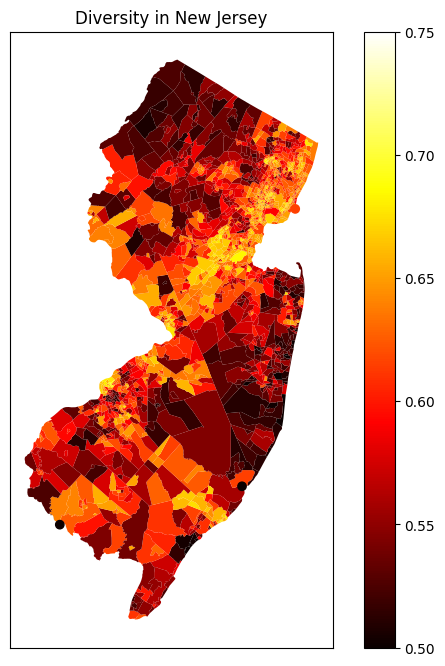

In [15]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 8)

ax = gdf_di.plot(
    "diversity",
    cmap="hot",
    # edgecolor="black",
    legend=True,
    vmin=0.5,
    vmax=0.75,
)

ax.set_title(f"Diversity in {censusdis.states.STATE_NAMES_FROM_IDS[STATE]}")

ax.tick_params(
    left=False,
    right=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)